#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [1]:
import sys

sys.path.append(
    "../../lab_02/template"
)  # This goes up twice in the directories tree (hence in labs)
# then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [2]:
import grid_search  # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import *  # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from test_utils import test

%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:
def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.

    >>> least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least squares: TODO
    # returns mse, and optimal weights
   
    optimal_w = np.matmul(np.linalg.inv(np.matmul(tx.T, tx)), tx.T).dot(y)
    optimal_e = y - tx.dot(optimal_w)
    N = y.shape[0]
    optimal_loss = (1/N)*(optimal_e.T.dot(optimal_e))
    
    return optimal_w, optimal_loss
    # ***************************************************

### You can test your implementation here

In [5]:
test(least_squares)
# NB:
#
# Due to precision issues,
# the output might not be exactly the same
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:)

❌ The are some issues with your implementation of `least_squares`:
**********************************************************************
File "__main__", line 13, in least_squares
Failed example:
    least_squares(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]))
Expected:
    (array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)
Got:
    (array([ 0.21212121, -0.12121212]), 1.4251881588465545e-32)
**********************************************************************


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obta|ined
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # least square or grid search: TODO
    # this code should compare the optimal weights obtained
    # by least squares vs. grid search
    
    # Compute optimal weights using grid search
    # Calculate loss and optimal mse and weights
    grid_losses = grid_search(y, tx, w0, w1)
    optimal_mse = np.amin(grid_losses)
    optimal_weights_idxs = np.unravel_index(grid_losses.argmin(), grid_losses.shape)
    
    # Store the optimal weights in an array to reference later
    optimal_weights = np.zeros((tx.shape[1],), dtype = np.float64)
    optimal_weights[0] = w0[optimal_weights_idxs[0]]
    optimal_weights[1] = w0[optimal_weights_idxs[1]]
    
    # Print out the optimal weights
    print(f'Optimal weights obtained from grid search: {optimal_weights}')
    print(f'Optimal weights obtained from least square: {least_squares(y, tx)}')
    # ***************************************************

Test it here

In [7]:
test_your_least_squares()

Optimal weights obtained from grid search: [50. 50.]
Optimal weights obtained from least square: (array([73.293922  , 13.47971243]), 30.771775737658796)


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [9]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.

    Returns:
        poly: numpy array of shape (N,d+1)

    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    
    # calculate for 0th power
    res = np.empty((x.shape[0], degree + 1), dtype = np.float64)
    for d in range(degree + 1):
        res[:, d] = np.apply_along_axis(lambda s: s**d, 0, x)
    
    return res
    # ***************************************************

In [10]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Once your implementation of `build_poly` passes the test, copy it to `build_polynomial.py`
Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [11]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
    and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]

    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)
    
    for ind, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # form the data to do polynomial regression.: TODO
                
        # Build polynomial functions of X
        poly_x = build_poly(x, degree)
        # ***************************************************
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # least square and calculate RMSE: TODO

        # calculate mse
        weights, mse = least_squares(y, poly_x)
        # Convert to rmse
        rmse = np.sqrt(2 * mse)
        # ***************************************************

        print(
            "Processing {i}th experiment, degree={d}, rmse={loss}".format(
                i=ind + 1, d=degree, loss=rmse
            )
        )
        # plot fit
        plot_fitted_curve(y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.6673335515781588
Processing 2th experiment, degree=3, rmse=0.3656912697732366
Processing 3th experiment, degree=7, rmse=0.3530707246084476
Processing 4th experiment, degree=12, rmse=0.4189669238262687


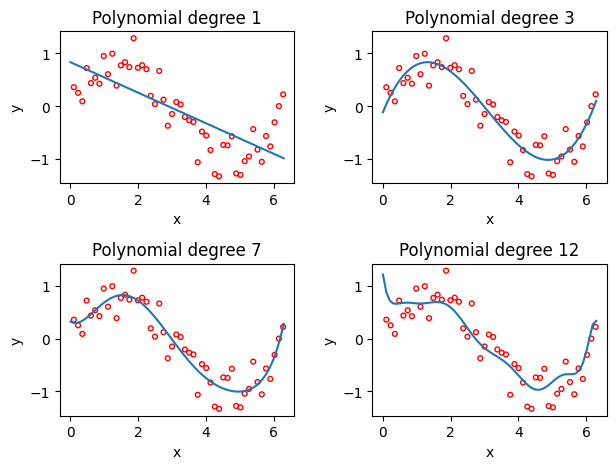

In [12]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

## Observations

- The linear model is not powerful enough to fit the data. Hence, the linear model is a case of underfitting. On the other hand, polynomial regression models are more expressive and can better fit the data

- No, as we need to be careful about overfitting as well. Polynomial degree 7 is the best fit as it is best able to fit the data with an acceptable level of error (not too much where the model underfits or not too little where the model overfits)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [13]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8
    you will have 80% of your data set dedicated to training
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.

    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.

    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.

    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    
    # Shuffle the data set
    # Generate a fixed random permutation for x and y
    perm = np.random.permutation(y.shape[0])
    # Shuffle the data by getting the permutated idxs
    shuffled_x, shuffled_y = x[perm], y[perm]
    
    # Split according to ratio
    N = y.shape[0]
    train_size = int(np.floor(N*ratio))
    
    # return train-test split datasets
    return shuffled_x[:train_size], shuffled_x[train_size:], shuffled_y[:train_size], shuffled_y[train_size:]
    # ***************************************************

In [14]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [15]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.

    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO

    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed = seed)
    # ***************************************************

    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    
    poly_x_train = build_poly(x_train, degree)
    poly_x_test = build_poly(x_test, degree)
    # ***************************************************
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate weight through least square: TODO
    
    optimal_train_w, optimal_train_loss = least_squares(y_train, poly_x_train)
    optimal_test_w, optimal_test_loss = least_squares(y_test, poly_x_test)    
    # ***************************************************
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate RMSE for train and test data,
    # and store them in rmse_tr and rmse_te respectively: TODO
    rmse_tr = np.sqrt(2 * optimal_train_loss)
    rmse_te = np.sqrt(2 * optimal_test_loss)
    # ***************************************************
    
    print(
        "proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
            p=ratio, d=degree, tr=rmse_tr, te=rmse_te
        )
    )
    
    return x_train, x_test, y_train, y_test, optimal_train_w

Demo time

proportion=0.9, degree=1, Training RMSE=0.698, Testing RMSE=0.222
proportion=0.9, degree=3, Training RMSE=0.374, Testing RMSE=0.122
proportion=0.9, degree=7, Training RMSE=0.359, Testing RMSE=1.297
proportion=0.9, degree=12, Training RMSE=0.407, Testing RMSE=2.325
proportion=0.7, degree=1, Training RMSE=0.730, Testing RMSE=0.463
proportion=0.7, degree=3, Training RMSE=0.352, Testing RMSE=0.260
proportion=0.7, degree=7, Training RMSE=0.322, Testing RMSE=0.171
proportion=0.7, degree=12, Training RMSE=1.368, Testing RMSE=0.885
proportion=0.5, degree=1, Training RMSE=0.643, Testing RMSE=0.636
proportion=0.5, degree=3, Training RMSE=0.338, Testing RMSE=0.361
proportion=0.5, degree=7, Training RMSE=0.329, Testing RMSE=0.349
proportion=0.5, degree=12, Training RMSE=0.727, Testing RMSE=0.364
proportion=0.1, degree=1, Training RMSE=0.605, Testing RMSE=0.661
proportion=0.1, degree=3, Training RMSE=0.121, Testing RMSE=0.354
proportion=0.1, degree=7, Training RMSE=1.573, Testing RMSE=0.349
proport

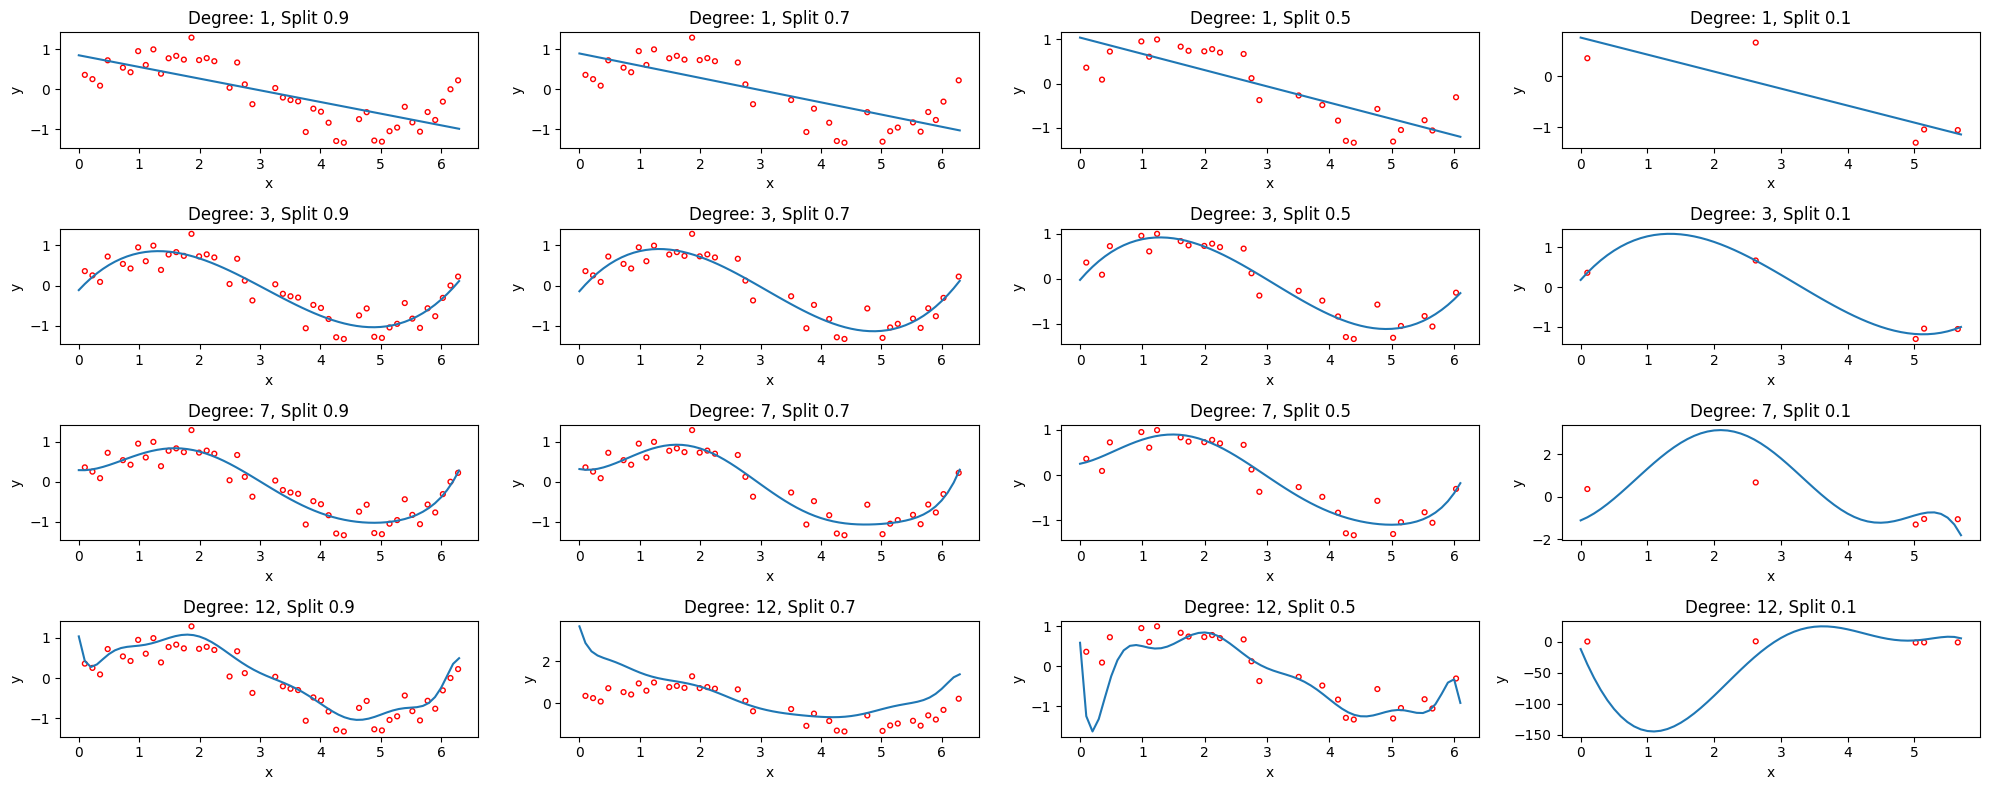

In [16]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20, 8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(
            x, y, degree, split_ratio, seed
        )
        plot_fitted_curve(y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f"Degree: {degree}, Split {split_ratio}")
plt.tight_layout()

Your graph should look like this:

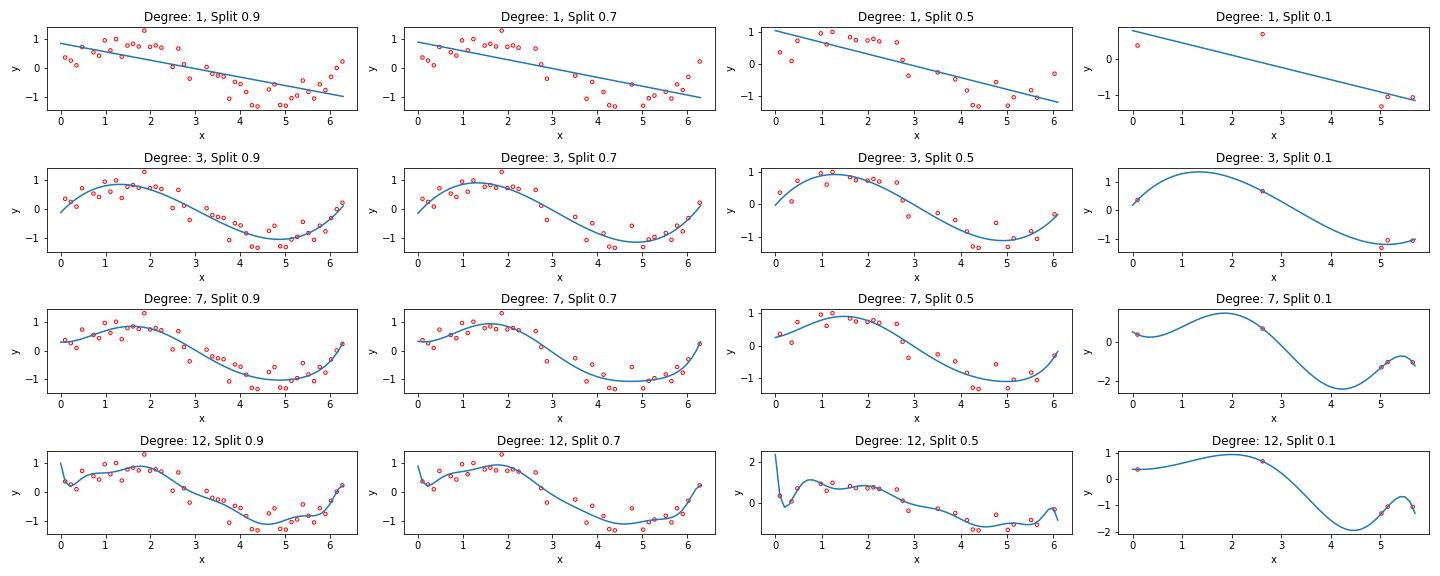![alt text](split_demo.png)

## Observations

<u>Degree of 3</u>
- Makes sense. As the size of training dataset gets smaller (value of proportion decreases), train RMSE decreases while test RMSE increases for degree of 3. This make sense as with lesser data to train model with, the model is more prone to overfitting and this leads to decrease in train RMSE and increase in test RMSE.

<u>Degree of 7 and 12</u>
- Does not make sense. The same observations seen in degree of 3 is not seen with the other degrees. This can be due to that the high degree results in a model too complex for the task and with lesser training data, the model is not able to fit to the function.

<u>Which split is better? Why?</u>
- Split of 0.9 is the best. There is sufficient data for model to be fitted on without overfitting, as seen from comparable (slightly better) train RMSE than other split proportions and the lowest test RMSE.

<u>The test RMSE for degree 12 is ridiculously high for the split 10%-90%. Why do you think this is the case?</u>
- Train dataset has high flexibility to fit the data closely. This results in the model learning the noise in the data as well and overfitting thereby causing high test RMSE.

<u>BONUS: Imagine you have 5000 samples instead of 50. Which split might be better in that situation?</u>
- Split of 0.7. Have more training data to fit model with, but the test size is still considerably large enough.

# Ridge Regression
Please fill in the function below.

In [17]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.

    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.

    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
    
    
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 0)
    array([ 0.21212121, -0.12121212])
    >>> ridge_regression(np.array([0.1,0.2]), np.array([[2.3, 3.2], [1., 0.1]]), 1)
    array([0.03947092, 0.00319628])
    """
    
    # Clarification: lecture notes used 2N here but MSE should be N only?
    # Calculate optimal weights
    num_samples = y.shape[0]
    num_params = tx.shape[1]
    
    inverse_product = np.linalg.inv(np.matmul(tx.T, tx) + (2*num_samples*lambda_)*np.identity(num_params))
    optimal_w = np.matmul(inverse_product, tx.T).dot(y)
    
    # Calculate loss
    # optimal_e = y - tx.dot(optimal_w)
    # optimal_loss = (1/2*N)*(optimal_e.T.dot(optimal_e))
    
    return optimal_w

In [18]:
test(ridge_regression)

✅ Your `ridge_regression` passed 2 tests.


In [19]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data, and return train and test data: TODO
    
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed = seed)
    # ***************************************************
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    
    poly_x_train = build_poly(x_train, degree)
    poly_x_test = build_poly(x_test, degree)
    # ***************************************************

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ridge regression with a given lambda

        # Calculate train loss
        optimal_train_w = ridge_regression(y_train, poly_x_train, lambda_)
        optimal_train_e = y_train - poly_x_train.dot(optimal_train_w)
        N = y_train.shape[0]
        optimal_train_mse = (1/2*N)*(optimal_train_e.T.dot(optimal_train_e))
        optimal_train_rmse = np.sqrt(2 * optimal_train_mse)
        rmse_tr.append(optimal_train_rmse)
        
        # Calculate test loss
        optimal_test_w = ridge_regression(y_test, poly_x_test, lambda_)
        optimal_test_e = y_test - poly_x_test.dot(optimal_test_w)
        N = y_test.shape[0]
        optimal_test_mse = (1/2*N)*(optimal_test_e.T.dot(optimal_test_e))
        optimal_test_rmse = np.sqrt(2 * optimal_test_mse)
        rmse_te.append(optimal_test_rmse)
        # ***************************************************
        
        print(
            "proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]
            )
        )
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=5.681, Testing RMSE=5.626
proportion=0.5, degree=7, lambda=0.000, Training RMSE=5.681, Testing RMSE=5.639
proportion=0.5, degree=7, lambda=0.000, Training RMSE=5.682, Testing RMSE=5.657
proportion=0.5, degree=7, lambda=0.000, Training RMSE=5.685, Testing RMSE=5.674
proportion=0.5, degree=7, lambda=0.000, Training RMSE=5.694, Testing RMSE=5.686
proportion=0.5, degree=7, lambda=0.001, Training RMSE=5.710, Testing RMSE=5.692
proportion=0.5, degree=7, lambda=0.001, Training RMSE=5.730, Testing RMSE=5.697
proportion=0.5, degree=7, lambda=0.003, Training RMSE=5.756, Testing RMSE=5.702
proportion=0.5, degree=7, lambda=0.007, Training RMSE=5.804, Testing RMSE=5.711
proportion=0.5, degree=7, lambda=0.016, Training RMSE=5.914, Testing RMSE=5.736
proportion=0.5, degree=7, lambda=0.037, Training RMSE=6.150, Testing RMSE=5.811
proportion=0.5, degree=7, lambda=0.085, Training RMSE=6.611, Testing RMSE=6.019
proportion=0.5, degree=7, lambda=0.193, 

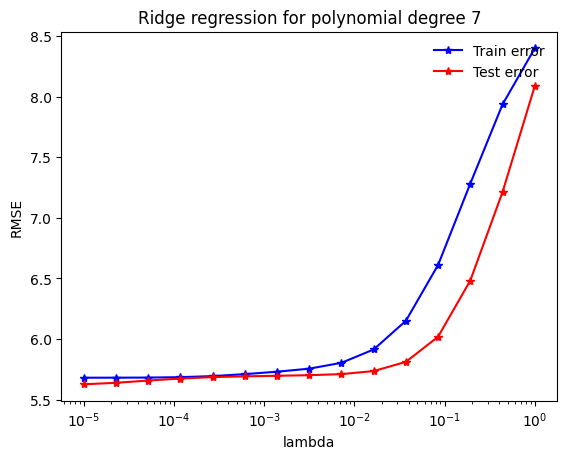

In [20]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)

Your plot should look like:

![alt text](ridge_regression.png)